# Project CS - Shallow water model

We consider a fluid flowing in one dimension. 

When the fluid deepness of a river or lagoon isn't too big we can consider the fluid is flowing in one dimension, the main direction ($x$ in a 1D model). Starting from the Navier-Stokes equation we can write a reduced model, called **Shallow Water** describing the fluid flow in terms of the fluid heigh $h$ and the flux $q$. The variable $q$ is $uh$ being $u$ the averaged velocity in the $y$ direction, $u(x,t) = { 1 \over h} \int_h u(x,y,t) dy$. 

We have then two variables, depending on time and space, $h = h(x,t)$; $q=q(x,t)$ and we can write the **differential conservation law** of mass and momentum as

$$\dfrac{\partial h}{\partial t} +  \dfrac{\partial q}{\partial x} = 0$$

$$\dfrac{\partial q}{\partial t} +  \partial \dfrac{ (q^2/h + 1/2 g h^2)}{\partial x} = S$$

where $g$ stand by gravity and $S$ is a source term which could model friction, Coriolis forces, surface tension, or the wind over the free surface $h$. The system can be expressed as

$$\dfrac{\partial U}{\partial t} +  \dfrac{\partial F(U)}{\partial x} = S$$

with $F(U)$ the flux and $U = (h,q)^T$ the conserved variables. 

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib import cm

import scipy.sparse as sp

%matplotlib inline

### A - Finite Differences - MacCormak

Implement the MacCormack method.

This second-order finite difference method was introduced by Robert W. MacCormack in 1969. The MacCormack method is the simplest and elegant approach adapted to hyperbolic equations. This is a predictor-corrector approach, i.e. it predicts in the 1st step an intermediate solution $U_i^{*}$ which is then corrected in a 2nd step. 

The algorithm is

* predictor

$$U_i^{*} = U_i^n - {\Delta t \over \Delta x}  ( F_{i+1}^{n} - F_i^{n} )$$

* corrector

$$U_i^{n+1} = { 1 \over 2} (U_i^n + U_i^{*}) - { 1 \over 2}   {\Delta t \over \Delta x}  ( F_{i}^{*} - F_{i-1}^{*} )$$

The MacCormack algorithm does not introduce diffusive errors but it is known to be dispersive  (Gibbs phenomenon) in high gradient regions.

#### Parameters

In [159]:
# Numerical parameters

# --------------------------------------------------------

# space variables

# number of points to define the mesh
Nx = 50
Ny = 50

# length of the mesh
L = 10.
M = 10.

# --------------------------------------------------------

# Spatial grid
x = np.linspace(0, L, Nx)
y = np.linspace(0, M, Ny)

dx = L/len(x)
dy = M/len(y)

# 2D representation
X, Y = np.meshgrid(x, y)

# --------------------------------------------------------

# time data

t0 = 0.
T  = .5

dt = 0.001

# --------------------------------------------------------

# constant
g = 9.81

CFL = dt/dx + dt/dy
CFL

0.01

##### Initial functions

In [295]:
import scipy.sparse as sp

def eta0_zero(x, y):            
    
    """  Zero initial height """
    
    eta_0 = np.zeros((len(x), len(y)))
    
    return eta_0

def eta0_one(x, y):            
    
    """  One initial height """
    
    eta_0 = np.ones((len(x), len(y)))
    
    return eta_0

def eta0_slope(x, y):            
    
    """  Smooth slope """
    
    eta_0 = np.zeros((len(x), len(y)))
    eta_0 = 1. + .05*x
    
    return eta_0

def eta0_dam(x, y):    
    
    """  Discontinuous initial condition - dam like shape """
    
    eta_0 = np.zeros((len(x), len(y)))
    
    # Data
    L      = x[-1]
    center = L/4
    
    eta_0 = 1. + 0.2*(x<center)
    
    return eta_0

##### Topology

In [296]:
# Different possible bottom

def zero_bump(x, y):
    
    """ No bump function """
    
    # Initialisation
    f  = np.zeros((len(x), len(y)))
    df = np.zeros((len(x), len(y)))

    return (f, df)

def one_bump(x, y):
    
    """ Elevated bottom function """

    # Initialisation
    f  = np.ones((len(x), len(y)))
    df = np.zeros((len(x), len(y)))
            
    return (f, df)

def gaussian_bump(x, y, B0, sigx, sigy, originx, originy, H):

    """ Gaussian function, equivalent to a bump at the bottom """
    
    # Initialisation
    f  = np.zeros((len(x), len(y)))
    df = np.zeros((len(x), len(y)))

    # ---------------------------------------------

    L = x[-1,-1]
    M = y[-1,-1]
    
    # ---------------------------------------------
    
    # functions
    # f o h
    
    h  = (x-originx)**2 / (2*sigx**2) + (y-originy)**2 / (2*sigy**2)
    f  = H + B0*np.exp(-h)
    
    dh  = (x-originx) / sigx**2 + (y-originy) / sigy**2
    df = -dh * f

    return (f, df)

def slope_bump(x, y):
    
    """ Rectangular bump function """

    # Initialisation
    f  = np.zeros((len(x), len(y)))
    df = np.zeros((len(x), len(y)))
    
    # Data
    slope = .05
    
    # ---------------------------------------------
    
    # functions
    f  = slope*x
    df = np.linspace(slope, slope, len(x))
    
    return (f, df)

def beach_bump(x, y):
    
    """ Beach like bump function """

    # Initialisation
    f  = np.zeros((len(x), len(y)))
    df = np.zeros((len(x), len(y)))
    
    # Data
    L     = x[-1,-1] # length mesh
    slope = .05
    
    # ---------------------------------------------
    
    # functions
    height = .2
    om     = np.pi/L # pulsation
    coeff  = .5 # coefficient to reduce inclinasion of bump
    
    f      = height + coeff*np.cos(om*x)
    df     = -om * coeff*np.sin(om*x)
    
    return (f, df)

##### Flux vector - BC

In [297]:
def fill_F(U, g):
    
    """  Fill Flux vector - F==F(U) """
    
    F = U.copy()
    
    F[:,:,0] = U[:,:,1] # hu
    F[:,:,1] = U[:,:,1]**2/U[:,:,0] + .5*g*U[:,:,0]**2 # u²h + 1/2gh²
    F[:,:,2] = U[:,:,1]*U[:,:,2]/U[:,:,0] #huv
    
    return F

def fill_G(U, g):
    
    """  Fill Flux vector - G==F(V) """
    
    G = U.copy()
    
    G[:,:,0] = U[:,:,2] # hv
    G[:,:,1] = U[:,:,1]*U[:,:,2]/U[:,:,0] #huv
    G[:,:,2] = U[:,:,2]**2/U[:,:,0] + .5*g*U[:,:,0]**2 # v²h + 1/2gh²
    
    return G

def BC(U):
    
    """  Boundary conditions """
    
    # height
    U[0,:,0]  = U[1,:,0]      # height x=0
    U[:,0,0]  = U[:,1,0]      # height y=0
    U[-1,:,0] = U[-2,:,0]     # height x=L
    U[:,-1,0] = U[:,-2,0]     # height y=M

    # flux qx
    U[0,:,1]  = U[-1,:,1] = 0 # flux   x=0 & x=L
    U[:,0,1]  = U[:,-1,1] = 0 # flux   y=0 & y=M
    
    # flux qy
    U[0,:,2]  = U[-1,:,2] = 0 # flux   x=0 & x=L
    U[:,0,2]  = U[:,-1,2] = 0 # flux   y=0 & y=M
    
    return

##### Right hand side member - S

In [298]:
def S(u, x, y, f, mu, rho, g, eps):

    """ Shear stress + Topology """

    # Splitting vector
    h  = u[:,:,0]
    qx = u[:,:,1]
    qy = u[:,:,2]
    
    # -------------------------------------------------------------
    
    # Initialisation
    tau = np.zeros_like(u)
    Bx  = np.zeros_like(u)
    
    dfx = np.zeros((len(x), len(y)))
    dfy = np.zeros((len(x), len(y)))

    # -------------------------------------------------------------
    
    # Data
    L  = x[-1,-1]
    M  = y[-1,-1]
    
    dx = L/(len(x)-1)
    dy = M/(len(y)-1)

    # -------------------------------------------------------------
    
    # S shearing force
    
    #idx = np.where(h>eps)[0]
    
    tau[:,:,1] = mu*3*qx/h**2
    tau[:,:,2] = mu*3*qy/h**2
    
    dfx[1:,:]  = (f[1:,:] - f[:-1,:])/dx
    dfy[:,1:]  = (f[:,1:] - f[:,:-1])/dy

    Bx[:,:,1] = g*h*dfx
    Bx[:,:,2] = g*h*dfy
    
    return -Bx - tau/rho

##### System solver

In [299]:
# Matrix/Operator version

import scipy.sparse as sp

# --------------------------------------------------------

# Operators bounded to scheme used (MacCormak here)

def diverg_up_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [0, 1], (m, m)).toarray()
    
    Div[0,1]= 0
    Div[0,0] = Div[-1,-1] = 1
   
    return Div

def diverg_down_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [-1, 0], (m, m)).toarray()
    
    Div[-1,-2]= 1
    
    return Div
    
    
# Algorithm

def q_MC(x, y, dx, dy, t0, T, dt, u_ini, f, g, rho, mu, eps):

    """ The MacCormak method - 2D """
    
    u      = u_ini.copy();
    u_star = u_ini.copy();
    unew   = u_ini.copy();
    
    h      = [u[:,:,0].copy()] # h variable
    qx     = [u[:,:,1].copy()] # q variable
    qy     = [u[:,:,2].copy()] # q variable
    
    # -------------------------------------------
    
    Div_down = diverg_down_op(len(u[:,0]))
    Div_up   = diverg_up_op(len(u[:,0]))
    
    # -------------------------------------------
    
    npas = int(T/dt)
    t      = t0
    k      = 0
    
    while k < npas:
        
        k += 1
        t += dt
        
        Surf = S(u, x, y, f, mu, rho, g, eps)
        
        F  = fill_F(u, g)
        G  = fill_G(u, g)
                
        # predictor solution
        u_star[:-1,:-1,:] = u[:-1,:-1,:] - dt*((F[1:,:-1,:]-F[:-1,:-1,:])/dx + (G[:-1,1:,:]-G[:-1,:-1,:])/dy - Surf[:-1,:-1,:])

        # Periodic BCs:
        BC(u_star)

        # -----------------------------------------------------------------------------------------
        
        Surf_star = S(u_star, x, y, f, mu, rho, g, eps)

        F_star  = fill_F(u_star, g)
        G_star  = fill_G(u_star, g)        
        
        # corrector solution
        unew[1:,1:,:] = .5*(u[1:,1:,:]+u_star[1:,1:,:]) - dt*( (F_star[1:,1:,:]-F_star[:-1,1:,:])/dx + (G_star[1:,1:,:]-G_star[1:,:-1,:])/dy - Surf_star[1:,1:,:] )

        # Periodic BCs:
        BC(unew)

        if (k%30)==0: #We only take some values (every a in i%a)
            h.append(unew[:,:,0].copy()) # vector containing     h(x,T) for every i%a iteration(s)
            qx.append(unew[:,:,1].copy()) # vector containing q=hu(x,T) for every i%a iteration(s)
            qy.append(unew[:,:,2].copy()) # vector containing r=hv(x,T) for every i%a iteration(s)

        u = unew.copy()         # vector containing u(x,T)

    return (h, qx, qy, t)

##### Bottom function

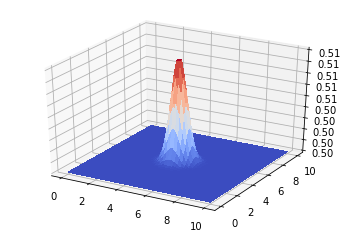

In [301]:
# Data

origin_x = L/2  # Origin bump x0
origin_y = M/2  # Origin bump y0

sigx = .5 # Width bump in x
sigy = .5 # Width bump in y

B0 = .01   # Height bump

H  = .5   # Height bottom

(B, Bx)    = gaussian_bump(X, Y, B0, sigx, sigy, origin_x, origin_y, H)#beach_bump(X, Y)#gaussian_bump(X, Y, B0, sigx, sigy, origin_x, origin_y, H)

# Plot the surface
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, B, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

##### Polynomial speed case

In [302]:
# Initial eta
eta0 = eta0_slope(X, Y)
f    = B

# Initial height
h0   = (eta0 - f)*(eta0>f)

# Initial flux
q0x   = np.zeros((len(x), len(y)))
q0y   = np.zeros((len(x), len(y)))

# Concatenation
n = len(x)
m = len(y)

u_ini = np.zeros((n, m, 3))
u_ini[:,:,0] = h0
u_ini[:,:,1] = q0x
u_ini[:,:,2] = q0y

BC(u_ini)

In [305]:
mu  = 0.05
T   = 1.
rho = 10**3 #[kg.m-3] water volumic mass

# Precision over height
eps = 5*10**-2

(h, qx, qy, t_final) = q_MC(X, Y, dx, dy, t0, T, dt, u_ini, f, g, rho, mu, eps)

print('\nWe check for stability')
print('At final time t = {:.0f} s\n'.format(t_final))
print('H_final  : h(x=L, y=M, t={:.0f}) = {} \n'.format(t_final, h[-1][-1][-1]))
print('Qx_final : q(x=L, y=M, t={:.0f}) = {}'.format(t_final, qx[-1][-1][-1]))
print('Qy_final : q(x=L, y=M, t={:.0f}) = {}'.format(t_final, qy[-1][-1][-1]))

<ipython-input-297-0bff7c800640>:8: RuntimeWarning: overflow encountered in square
  F[:,:,1] = U[:,:,1]**2/U[:,:,0] + .5*g*U[:,:,0]**2 # u²h + 1/2gh²
<ipython-input-297-0bff7c800640>:9: RuntimeWarning: overflow encountered in multiply
  F[:,:,2] = U[:,:,1]*U[:,:,2]/U[:,:,0] #huv
<ipython-input-297-0bff7c800640>:20: RuntimeWarning: overflow encountered in multiply
  G[:,:,1] = U[:,:,1]*U[:,:,2]/U[:,:,0] #huv
<ipython-input-297-0bff7c800640>:21: RuntimeWarning: overflow encountered in square
  G[:,:,2] = U[:,:,2]**2/U[:,:,0] + .5*g*U[:,:,0]**2 # v²h + 1/2gh²
<ipython-input-299-f361a7e3083a>:80: RuntimeWarning: invalid value encountered in subtract
  unew[1:,1:,:] = .5*(u[1:,1:,:]+u_star[1:,1:,:]) - dt*( (F_star[1:,1:,:]-F_star[:-1,1:,:])/dx + (G_star[1:,1:,:]-G_star[1:,:-1,:])/dy - Surf_star[1:,1:,:] )
<ipython-input-299-f361a7e3083a>:80: RuntimeWarning: invalid value encountered in add
  unew[1:,1:,:] = .5*(u[1:,1:,:]+u_star[1:,1:,:]) - dt*( (F_star[1:,1:,:]-F_star[:-1,1:,:])/dx + (G_s


We check for stability
At final time t = 1 s

H_final  : h(x=L, y=M, t=1) = nan 

Qx_final : q(x=L, y=M, t=1) = 0.0
Qy_final : q(x=L, y=M, t=1) = 0.0


<ipython-input-304-c424a6d31d55>:4: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  plot[0] = ax.plot_surface(X, Y, z[frame_number], cmap='magma')
C:\Users\vltn0\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


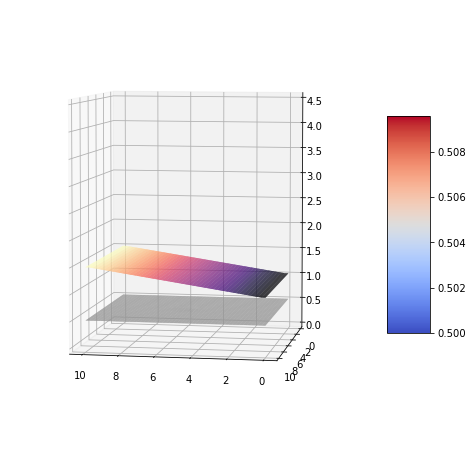

In [304]:
# Plot the surface
def update_plot(frame_number, z, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, z[frame_number], cmap='magma')

fig = plt.figure(figsize=(8,8))
ax  = fig.gca(projection='3d')
ax.plot_surface(X, Y, f, color='0.75', rstride=1, cstride=1)

plot = [ax.plot_surface(X, Y, (h+B)[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0, 4.5)
fig.colorbar(surf, shrink=0.5, aspect=5)

anim = animation.FuncAnimation(fig, update_plot, len(h), fargs=(h+B, plot))
ax.view_init(elev=5., azim=100)

HTML(anim.to_jshtml())

#### Animation - Smooth IC

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(h)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h
line2, = ax.plot([], [], '--', color='orange', linewidth=2)  # Line plot for B
line3, = ax.plot([], [], 'g-', linewidth=2)  # Line plot for u

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((0, 10, -1, 5))              # Set the bounds of the plot

def plot_q(n):
    line1.set_data(x, (h+B)[n])
    line2.set_data(x, B)
    #line3.set_data(x, u[n])

    return[line1, line2, line3]
    
anim = animation.FuncAnimation(fig, plot_q, frames=n)  # Animate the solution

plt.legend(['h+B', 'B', 'u'], loc=3)

#plt.show()
HTML(anim.to_jshtml())